# IMDB 영화리뷰 감성분석 - LSTM

In [1]:
from tensorflow.keras.datasets import imdb
(X_train, y_train), (X_test, y_test) = imdb.load_data()

17473536/17464789 [==============================] - 0s 0us/step


In [2]:
X_train.shape, X_test.shape

((25000,), (25000,))

In [3]:
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [4]:
# 등장한 단어수
len(imdb.get_word_index())

1654784/1641221 [==============================] - 0s 0us/step


88584

In [5]:
# 리뷰 최대 길이, 평균 길이
max(len(s) for s in X_train), sum(map(len, X_train)) / len(X_train)

(2494, 238.71364)

### LSTM으로 감성분석
- 단어 빈도수: 10,000 (총 88,584)
- 리뷰 단어수: 500 (최대 2,494)
- 최대 데이터 개수 ==> 나의 몫 ^^
    - train: 25,000, valid: 10,000, test: 15,000
- 수업시간
    - train: 20,000, test: 5,000 (valid: 20%)

In [6]:
# 나의 몫
# from sklearn.modelselection import train_test_split
# X_test, X_valid, y_test, y_valid = train_test_split(

# )

In [7]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [8]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [9]:
num_words = 10000
(X_train, y_train), (_, _) = imdb.load_data(num_words=num_words)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.2, random_state=seed
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20000,), (5000,), (20000,), (5000,))

In [11]:
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
X_train.shape, X_test.shape

((20000, 500), (5000, 500))

- 모델

In [12]:
model = Sequential([
    Embedding(num_words, 100, input_length=max_len),
    LSTM(128),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile('adam', 'binary_crossentropy', ['accuracy'])

In [14]:
model_path = 'best-imdb-lstm.h5'
mc = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
es = EarlyStopping(patience=10)

In [15]:
hist = model.fit(
    X_train, y_train, validation_split=0.2,
    epochs=30, batch_size=64, callbacks=[mc,es]
)

Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 0.5115 - accuracy: 0.7401
Epoch 1: val_loss improved from inf to 0.39437, saving model to best-imdb-lstm.h5
250/250 [==============================] - 15s 32ms/step - loss: 0.5115 - accuracy: 0.7401 - val_loss: 0.3944 - val_accuracy: 0.8395
Epoch 2/30
249/250 [============================>.] - ETA: 0s - loss: 0.2872 - accuracy: 0.8874
Epoch 2: val_loss improved from 0.39437 to 0.34212, saving model to best-imdb-lstm.h5
250/250 [==============================] - 8s 31ms/step - loss: 0.2879 - accuracy: 0.8871 - val_loss: 0.3421 - val_accuracy: 0.8608
Epoch 3/30
249/250 [============================>.] - ETA: 0s - loss: 0.2093 - accuracy: 0.9214
Epoch 3: val_loss did not improve from 0.34212
250/250 [==============================] - 7s 30ms/step - loss: 0.2093 - accuracy: 0.9213 - val_loss: 0.3664 - val_accuracy: 0.8457
Epoch 4/30
249/250 [============================>.] - ETA: 0s - loss: 0.1543 - accuracy: 0.9449
Epoc

In [16]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

157/157 [==============================] - 2s 11ms/step - loss: 0.3598 - accuracy: 0.8544


[0.3597688674926758, 0.8543999791145325]

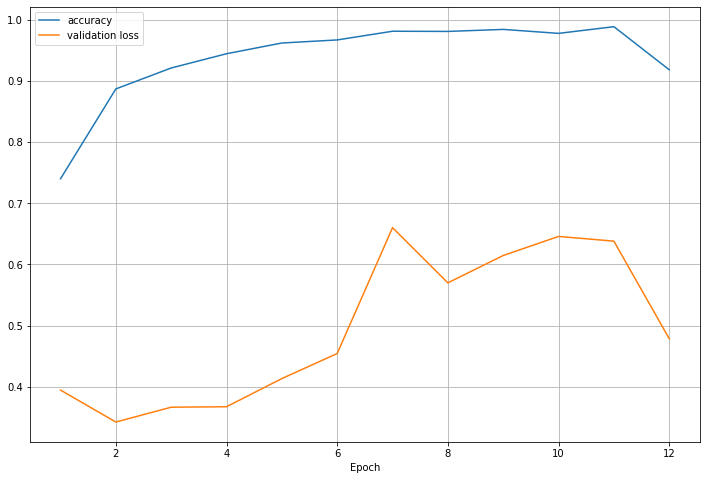

In [17]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.grid(), plt.legend(), plt.xlabel('Epoch')
plt.show()